In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
from typing import Tuple

import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.modelzoo.customlstm import CustomLSTM
from neuralhydrology.utils.config import Config
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

sys.path.append("/app")
from visualizations.scripts.drawer import russia_plots, russia_plots_n

# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")


Using device: cuda

NVIDIA GeForce RTX 4080 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [8]:
def state_drawer():
    pass


def lstm_layer_correlation(
    state_dict: dict,
    date_range: np.ndarray,
    meteo_array: np.ndarray,
    data_name: str,
    interest_states: tuple = ("c_n", "h_n"),
    correlation_threshold: float = 0.7,
    draw_plot: bool = False,
) -> Tuple[dict, dict]:
    """_summary_.

    Args:
    ----
        state_dict (dict): _description_
        date_range (np.ndarray): _description_
        meteo_array (np.ndarray): _description_

    Returns:
    -------
        Tuple[dict, dict]: _description_

    """
    if len(date_range) != len(meteo_array):
        date_range = date_range[: len(meteo_array)]
    best_correlation = {}
    state_correlation = {}

    for layer in interest_states:
        # Concatenate all batches into one tensor that contains the final time step of each sample.
        cell_states = torch.cat([state_dict[layer][:, -1, :]], dim=0)
        cell_states = cell_states.detach().numpy()

        # Load the forcings input for the corresponding date range
        corr_data = {}
        state_correlation[layer] = {}
        for i in range(cell_states[:, :].shape[1]):
            state_corr = cell_states[:, i]
            if len(state_corr) != len(meteo_array):
                state_corr = state_corr[: len(meteo_array)]
            corr_coef = np.corrcoef(state_corr, meteo_array)
            corr_coef = corr_coef[0, 1]
            state_correlation[layer][f"{i}"] = corr_coef
            if corr_coef > correlation_threshold:
                corr_data[f"{i}"] = corr_coef

        if len(corr_data) == 0:
            best_correlation[layer] = 0.01
        #     print(
        #         f"No states correlated with {data_name} for {layer} with threshold of {correlation_threshold}"
        #     )
        else:
            cell_value = int(max(corr_data, key=corr_data.get))
            best_correlation[layer] = corr_data[f"{cell_value}"]
            if draw_plot:
                _, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
                # ax.plot(date_range.to_numpy(), cell_states, c="C0", alpha=0.2)

                plot_cell = cell_states[:, cell_value]

                if len(plot_cell) != len(meteo_array):
                    plot_cell = plot_cell[: len(meteo_array)]

                ax.plot(date_range, plot_cell, c="red")
                ax.set_ylabel(f"{layer}")
                ax.set_title(
                    f" best cell state {cell_value} for {layer} layer, correlation={corr_data[f'{cell_value}']:.2f}",
                    fontsize=24,
                )
                ax2.set_ylabel(f"{data_name}")
                ax2.plot(date_range, meteo_array, c="blue")
                plt.tight_layout()

    for key, state_dict in state_correlation.items():
        state_correlation[key] = sorted(state_dict.items(), key=lambda item: item[1], reverse=True)[:10]
    return (best_correlation, state_correlation)


### Prepare model

In [4]:
config_file = Path(
    "/app/geo_data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/config.yml"
)

cudalstm_config = Config(config_file)

# create a new model instance with random weights
cuda_lstm = CudaLSTM(cfg=cudalstm_config)

# load the trained weights into the new model.
model_path = cudalstm_config.run_dir / "model_epoch024.pt"
model_weights = torch.load(
    str(model_path), map_location="cpu"
)  # load the weights from the file, creating the weight tensors on CPU
cuda_lstm.load_state_dict(model_weights)  # set the new model's weights to the values loaded from file
custom_lstm = CustomLSTM(cfg=cudalstm_config)  # create a new CustomLSTM (with random weights)
custom_lstm.copy_weights(cuda_lstm)  # copy the CudaLSTM weights into the CustomLSTM
# make sure we're in eval mode where dropout is deactivated
custom_lstm.eval()

# load the dataset
scaler = load_scaler(cudalstm_config.run_dir)
dataset = get_dataset(cudalstm_config, is_train=False, period="test", scaler=scaler)
dataloader = DataLoader(dataset, batch_size=731, shuffle=False, collate_fn=dataset.collate_fn)

example_states = custom_lstm(next(iter(dataloader)))
example_states.keys()


dict_keys(['h_n', 'c_n', 'i', 'f', 'g', 'o', 'y_hat'])

### Read geometry and model data results

In [5]:
gauges_file = gpd.read_file("../geo_data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file = ws_file[ws_file["new_area"] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "а) < 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "б) 100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "в) 2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "г) 10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "а) < 100 $км^2$",
        "б) 100 $км^2$ - 2 000 $км^2$",
        "в) 2 000 $км^2$ - 10 000 $км^2$",
        "г) 10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../geo_data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../geo_data/geometry/basin_districts_2024.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# basin_districts = basin_districts.drop([26, 27])
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

hbv_table = pd.read_csv(
    "./tables/HBV_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

gr4j_table = pd.read_csv(
    "./tables/GR4J_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
rfr_table = pd.read_csv(
    "./tables/res_rfr_cv.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_regional = pd.read_csv(
    "./tables/cudalstm_q_mm_day_mswep_era5_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_single = pd.read_csv(
    "./tables/Single_LSTM_table.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_no_static = pd.read_csv(
    "./tables/LSTM_no_static_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

common_index = (
    hbv_table.index.intersection(gr4j_table.index)
    .intersection(rfr_table.index)
    .intersection(lstm_regional.index)
    .intersection(ws_file.index)
    .intersection(lstm_single.index)
    .intersection(lstm_no_static.index)
)


ws_file = ws_file.loc[common_index, :]
gauges_file = gauges_file.loc[common_index, :]
gauges_file["size"] = np.NaN
gauges_file = gauges_file.combine_first(ws_file)
gauges_file = gauges_file.set_crs(epsg=4326)


In [6]:
test_date_range = pd.date_range(
    cudalstm_config.test_start_date,
    cudalstm_config.test_end_date - pd.Timedelta("1D"),
    freq="1D",
)


### Metrics by Geo Cluster

In [56]:
geo_cluster = gpd.read_file("tables/HydroATLAS_clustering.gpkg")
geo_cluster = geo_cluster.set_index("gauge_id")
geo_cluster.index = geo_cluster.index.astype(str)


### Metrics by Hydro Cluster

In [57]:
hydro_cluster = gpd.read_file("tables/Q_clustering.gpkg")
hydro_cluster = hydro_cluster.set_index("gauge_id")
hydro_cluster.index = hydro_cluster.index.astype(str)


### Metrics by area

In [58]:
ws_file


name_ru                        name_en  \
gauge_id                                                               
70158        р.Кичменьга - д.Захарово      r.Kichmen'ga - d.Zaharovo   
8290          р.Карабула - с.Карабула        r.Karabula - s.Karabula   
70583        р.Уфтюга - с.Богородское      r.Uftjuga - s.Bogorodskoe   
76408               р.Ай - г.Златоуст              r.Aj - g.Zlatoust   
72668            р.Алоля - д.Ермолово          r.Alolja - d.Ermolovo   
...                               ...                            ...   
10584         р.Тисулька - пгт Тисуль        r.Tisul'ka - pgt Tisul'   
72577            р.Луга - г.Кингисепп           r.Luga - g.Kingisepp   
8347            р.Топорок - г.Алзамай          r.Toporok - g.Alzamaj   
48069         р.Немина - пос.Немино-3        r.Nemina - pos.Nemino-3   
7174      р.Безымянная - пос.Мангутай  r.Bezymjannaja - pos.Mangutaj   

           new_area  ais_dif  \
gauge_id                       
70158      2010.248    0.012   
8290       4057.005    3.174   
70583       830.751    8.171   
76408      1072.801    4.214   
72668       683.497    9.351   
...             ...      ...   
10584       229.857    5.925   
72577     12388.675    3.213   
8347       1959.655    1.525   
48069       569.969    5.163   
7174        202.868    0.555   

                                                   geometry  \
gauge_id                                                      
70158     POLYGON ((45.286 60.474, 45.286 60.473, 45.287...   
8290      POLYGON ((97.485 58.343, 97.485 58.342, 97.485...   
70583     POLYGON ((39.57 60.427, 39.572 60.427, 39.572 ...   
76408     POLYGON ((59.775 55.314, 59.778 55.314, 59.778...   
72668     POLYGON ((29.328 56.878, 29.328 56.877, 29.335...   
...                                                     ...   
10584     POLYGON ((88.435 55.778, 88.435 55.777, 88.437...   
72577     POLYGON ((29.572 59.619, 29.573 59.619, 29.573...   
8347      POLYGON ((98.24 55.624, 98.246 55.624, 98.246 ...   
48069     POLYGON ((35.444 63.001, 35.451 63.001, 35.451...   
7174      POLYGON ((103.74 51.596, 103.74 51.596, 103.74...   

                                      size  
gauge_id                                    
70158      в) 2 000 $км^2$ - 10 000 $км^2$  
8290       в) 2 000 $км^2$ - 10 000 $км^2$  
70583         б) 100 $км^2$ - 2 000 $км^2$  
76408         б) 100 $км^2$ - 2 000 $км^2$  
72668         б) 100 $км^2$ - 2 000 $км^2$  
...                                    ...  
10584         б) 100 $км^2$ - 2 000 $км^2$  
72577     г) 10 000 $км^2$ - 50 000 $км^2$  
8347          б) 100 $км^2$ - 2 000 $км^2$  
48069         б) 100 $км^2$ - 2 000 $км^2$  
7174          б) 100 $км^2$ - 2 000 $км^2$  

[996 rows x 6 columns]

### Cell states vs Evaporation

In [22]:
evaporation_state = pd.DataFrame()
evaporation_depth = dict()

for gauge_id in tqdm(gauges_file.index):
    try:
        gauge_cor, gauge_state_cor = lstm_layer_correlation(
            state_dict=example_states,
            date_range=test_date_range.to_numpy(),
            meteo_array=pd.read_csv(
                f"../geo_data/meteo_grids_2024/gleam/E/{gauge_id}.csv",
                index_col="date",
                parse_dates=["date"],
            )
            .loc[test_date_range]
            .to_numpy()
            .ravel(),
            correlation_threshold=0.7,
            data_name="Испарение",
            draw_plot=False,
            # interest_states=("c_n"),
        )
        evaporation_state.loc[gauge_id, "r скрытый фильтр"] = gauge_cor["h_n"]
        evaporation_state.loc[gauge_id, "r фильтр состояния"] = gauge_cor["c_n"]
        evaporation_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
        gauge_state_cor = {cell: [int(i[0]) for i in vals] for cell, vals in gauge_state_cor.items()}
        evaporation_depth[gauge_id] = gauge_state_cor
    except FileNotFoundError:
        evaporation_state.loc[gauge_id, "r скрытый фильтр"] = 0.01
        evaporation_state.loc[gauge_id, "r фильтр состояния"] = 0.01
        evaporation_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
    # evaporation_state.loc[gauge_id, "r "] = gauge_cor["h_n"]
evaporation_state = gpd.GeoDataFrame(evaporation_state, geometry="geometry", crs="epsg:4326")


  0%|          | 0/996 [00:00<?, ?it/s]

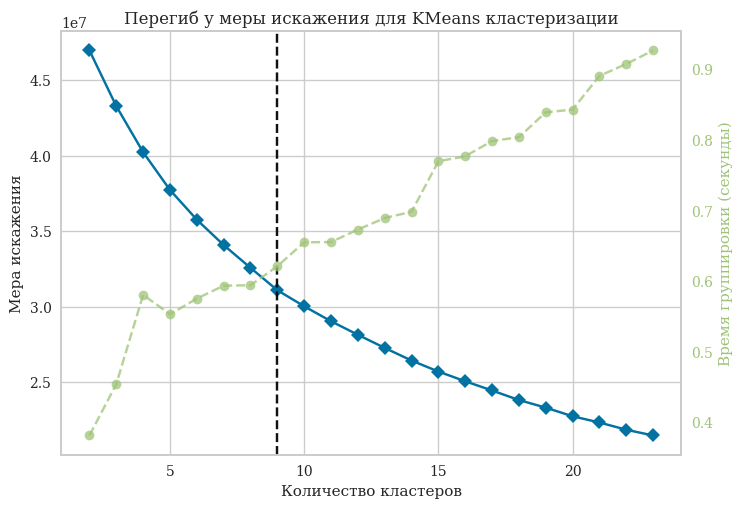

In [289]:
# Import ElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

evaporation_depth_c_n = (
    pd.DataFrame()
    .from_dict({gauge_id: cell_dict["c_n"] for gauge_id, cell_dict in evaporation_depth.items()})
    .T
)
evaporation_depth_h_n = (
    pd.DataFrame()
    .from_dict({gauge_id: cell_dict["h_n"] for gauge_id, cell_dict in evaporation_depth.items()})
    .T
)

raw_features = evaporation_depth_c_n.values

model = KMeans(random_state=42, init="k-means++", n_init=420)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 24), timings=True)
visualizer.fit(raw_features)  # Fit data to visualizer
visualizer.show();


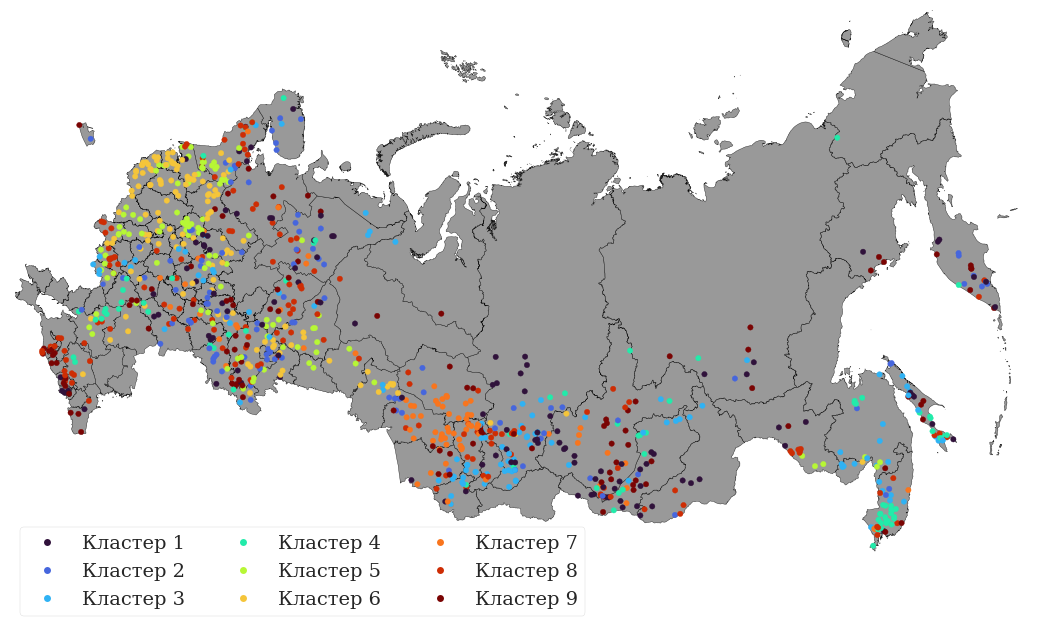

In [295]:
number_of_clusters = 9
raw_features = evaporation_depth_h_n.values
cluster_alg = KMeans(n_clusters=number_of_clusters, random_state=42, init="k-means++", n_init=420)

yhat_AC = cluster_alg.fit_predict(raw_features)
evaporation_depth_h_n["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.NaN

gauges_file = gauges_file.combine_first(evaporation_depth_h_n).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    # list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
)


In [198]:
import matplotlib.colors as mcolors
import plotly.express as px
from matplotlib import cm

cluster_stats = list()
for i, group_id in evaporation_depth_h_n.groupby("ResClust").groups.items():
    g_clust = (
        evaporation_depth_h_n.loc[group_id, evaporation_depth_h_n.columns[:-1]]
        .mode()
        .iloc[0]
        .to_frame()
        .T
    )

    g_clust.index = [i]
    g_clust.index.name = "Кластер"
    cluster_stats.append(g_clust)
cluster_stats = pd.concat(cluster_stats)
cluster_stats = cluster_stats.reset_index()
# cluster_stats = cluster_stats.rename(columns={"index": "Кластер"})
polar = pd.melt(cluster_stats, id_vars=["Кластер"])
polar["variable"] = [f"Кластер {int(i) + 1}" for i in polar["variable"]]

cmap_name: str = "turbo"
cmap = cm.get_cmap(cmap_name, number_of_clusters)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

fig_polar = px.line_polar(
    polar,
    r="value",
    theta="variable",
    color="Кластер",
    color_discrete_sequence=color_list,
    template="seaborn",
    height=900,
    width=1500,
)
fig_polar.update_layout(
    polar=dict(
        radialaxis=dict(showticklabels=False, ticks=""),
        angularaxis=dict(showticklabels=True, tickangle=0),
    ),
    legend_title_text="Кластеры",
    # legend_title_text=None,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0,
    ),
)
# fig_polar.write_image("./images/cluster_importance_tft.png")
plt.tight_layout()
fig_polar


<Figure size 800x550 with 0 Axes>

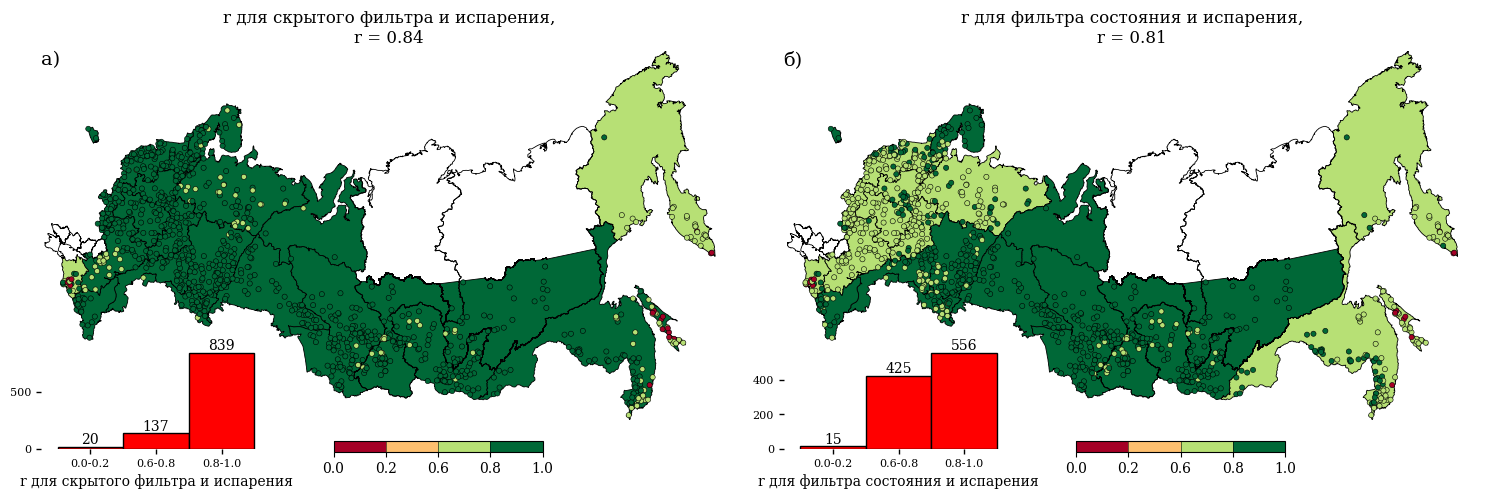

In [47]:
evaporation_h_n_r = evaporation_state["r скрытый фильтр"].median()
evaporation_c_n_r = evaporation_state["r фильтр состояния"].median()

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = evaporation_state.loc[
        [geom.intersects(gage_point) for gage_point in evaporation_state["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["r скрытый фильтр", "r фильтр состояния"]] = ugms_part[
        ["r скрытый фильтр", "r фильтр состояния"]
    ].median()

basin_districts.loc[[26, 27], ["r скрытый фильтр", "r фильтр состояния"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=evaporation_state,
    basemap_data=basemap_data,
    figsize=(15, 6),
    nrows=1,
    ncols=2,
    label_list=["а)", "б)"],
    list_of_limits=[0.0, 0.2, 0.6, 0.8, 1.0],
    columns_from_gdf=["r скрытый фильтр", "r фильтр состояния"],
    hist_name=["r для скрытого фильтра и испарения", "r для фильтра состояния и испарения"],
    with_histogram=True,
    title_text=[
        f"r для скрытого фильтра и испарения,\nr = {evaporation_h_n_r:.2f}",
        f"r для фильтра состояния и испарения,\nr = {evaporation_c_n_r:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


In [311]:
def ax_plot(
    gauge_id,
    cell_ax,
    meteo_ax,
    cell_data,
    meteo_data,
    data_range,
    cell_ax_title: str,
    cell_ax_ylabel: str,
    meteo_ax_title: str,
    meteo_ax_ylabel: str,
):
    cell_ax.plot(data_range, cell_data, c="red")
    cell_ax.set_ylabel(cell_ax_ylabel)
    cell_ax.set_title(
        cell_ax_title,
        fontsize=14,
    )
    cell_ax.set_xlim([pd.to_datetime("01/01/2019"), pd.to_datetime("01/01/2021")])
    cell_ax.grid(False)

    meteo_ax.plot(data_range, meteo_data, c="blue")
    meteo_ax.set_ylabel(meteo_ax_ylabel)
    meteo_ax.set_title(
        meteo_ax_title,
        fontsize=14,
    )
    meteo_ax.set_xlim([pd.to_datetime("01/01/2019"), pd.to_datetime("01/01/2021")])
    meteo_ax.grid(False)

    return None


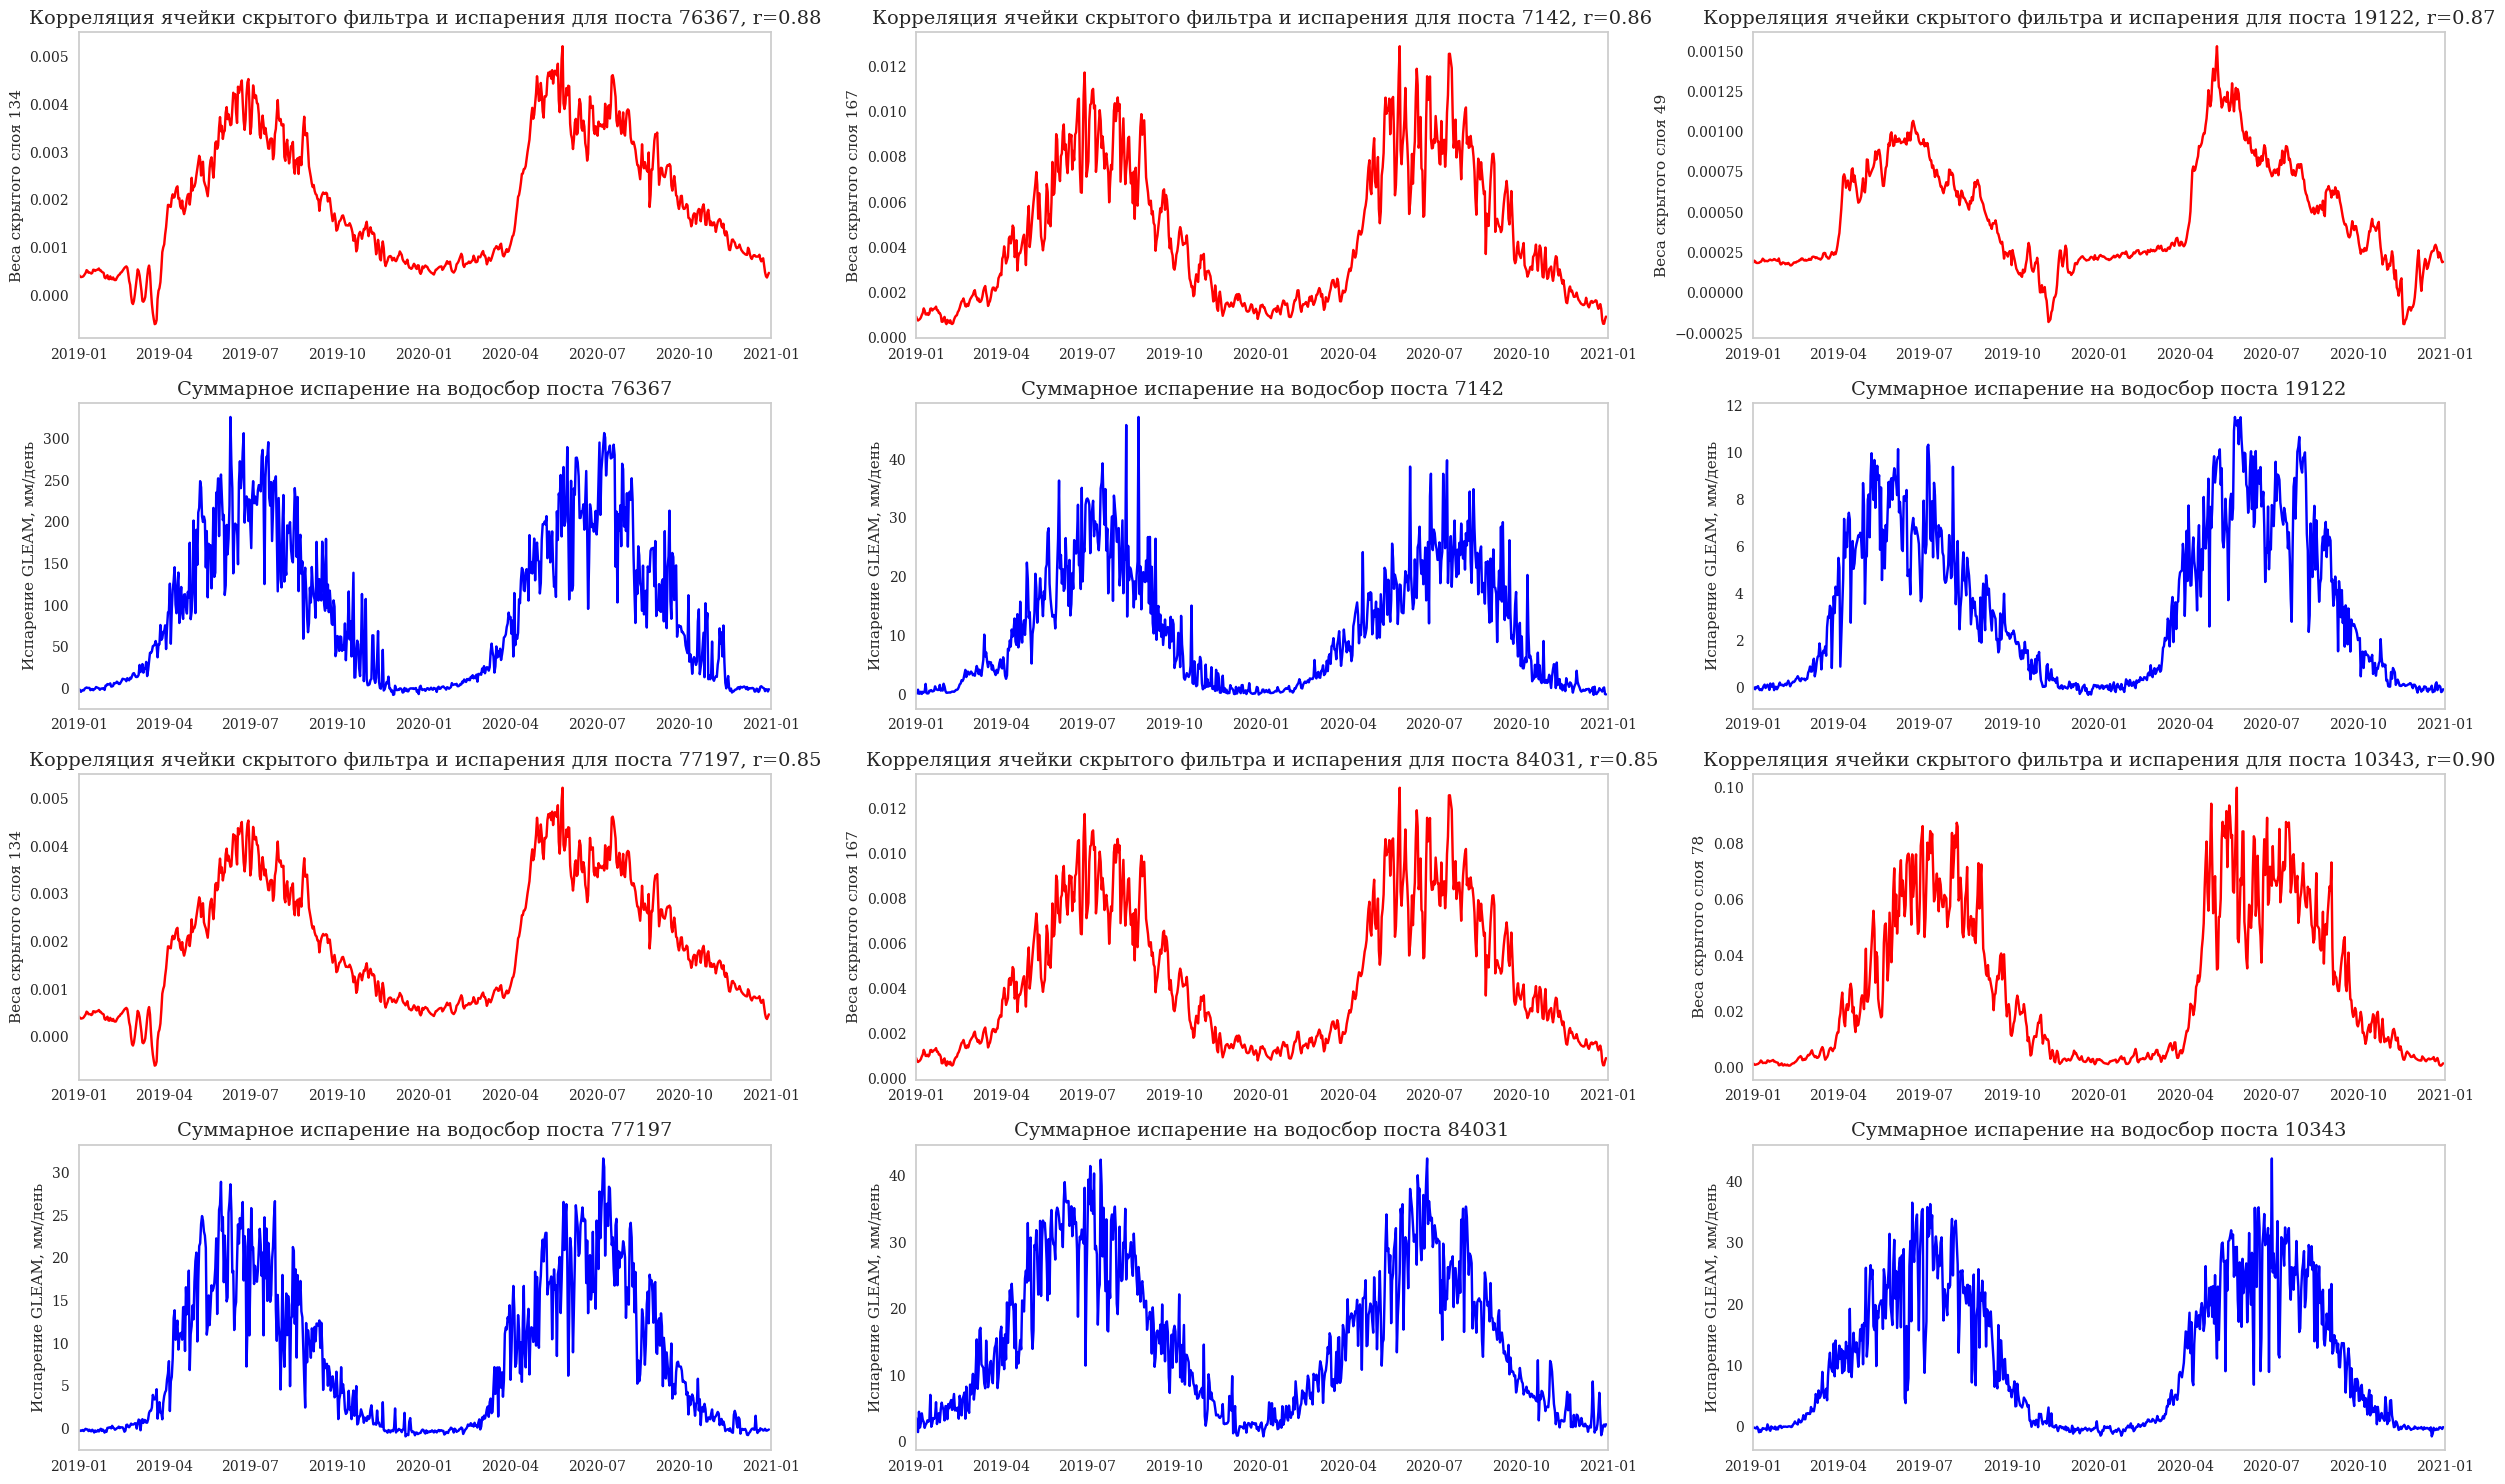

In [312]:
sample_evap = (
    evaporation_state.sort_values(by="r скрытый фильтр", ascending=False)
    .head(420)
    .sample(n=6, random_state=42)
)


# Create a figure
fig = plt.figure(figsize=(25, 15))

# Define the GridSpec
gs = gridspec.GridSpec(4, 3)
cell_axs = [0, 1, 2, 6, 7, 8]
meteo_axs = [3, 4, 5, 9, 10, 11]
# Add subplots
axs = [fig.add_subplot(gs[i, j]) for i in range(0, 4) for j in range(0, 3)]

for gauge_id, cell_i, meteo_j in zip(sample_evap.index, cell_axs, meteo_axs):
    plot_cell = torch.cat(
        [example_states["h_n"][:-1, -1, evaporation_depth[f"{gauge_id}"]["h_n"][0]]], dim=0
    )
    plot_cell = plot_cell.detach().numpy()

    meteo_array = (
        pd.read_csv(
            f"../geo_data/meteo_grids_2024/gleam/E/{gauge_id}.csv",
            index_col="date",
            parse_dates=["date"],
        )
        .loc[test_date_range.to_numpy()]
        .to_numpy()
        .ravel()
    )

    ax_plot(
        gauge_id=f"{gauge_id}",
        cell_ax=axs[cell_i],
        cell_ax_title=f"Корреляция ячейки скрытого фильтра и испарения для поста {gauge_id}, r={evaporation_state.loc[f'{gauge_id}', 'r скрытый фильтр']:.2f}",
        cell_ax_ylabel=f"Веса скрытого слоя {evaporation_depth[gauge_id]['h_n'][0]}",
        meteo_ax=axs[meteo_j],
        meteo_ax_title=f"Суммарное испарение на водосбор поста {gauge_id}",
        meteo_ax_ylabel="Испарение GLEAM, мм/день",
        cell_data=plot_cell,
        meteo_data=meteo_array,
        data_range=test_date_range.to_numpy(),
    )

    plt.tight_layout()


### Cell states vs SWE

In [287]:
swe_state = pd.DataFrame()
swe_depth = dict()

for gauge_id in tqdm(gauges_file.index):
    try:
        gauge_cor, gauge_state_cor = lstm_layer_correlation(
            state_dict=example_states,
            date_range=test_date_range.to_numpy(),
            meteo_array=pd.read_csv(
                f"../geo_data/snow_and_subsurface/era5_land/snow_depth_water_equivalent/{gauge_id}.csv",
                index_col="date",
                parse_dates=["date"],
            )
            .loc[test_date_range]
            .to_numpy()
            .ravel(),
            correlation_threshold=0.7,
            data_name="Обводненность снежного покрова",
        )
        swe_state.loc[gauge_id, "r скрытый фильтр"] = gauge_cor["h_n"]
        swe_state.loc[gauge_id, "r фильтр состояния"] = gauge_cor["c_n"]
        swe_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
        gauge_state_cor = {cell: [int(i[0]) for i in vals] for cell, vals in gauge_state_cor.items()}
        swe_depth[gauge_id] = gauge_state_cor
    except FileNotFoundError:
        swe_state.loc[gauge_id, "r скрытый фильтр"] = 0.01
        swe_state.loc[gauge_id, "r фильтр состояния"] = 0.01
        swe_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
    # swe_state.loc[gauge_id, "r "] = gauge_cor["h_n"]
swe_state = gpd.GeoDataFrame(swe_state, geometry="geometry", crs="epsg:4326")

  0%|          | 0/996 [00:00<?, ?it/s]

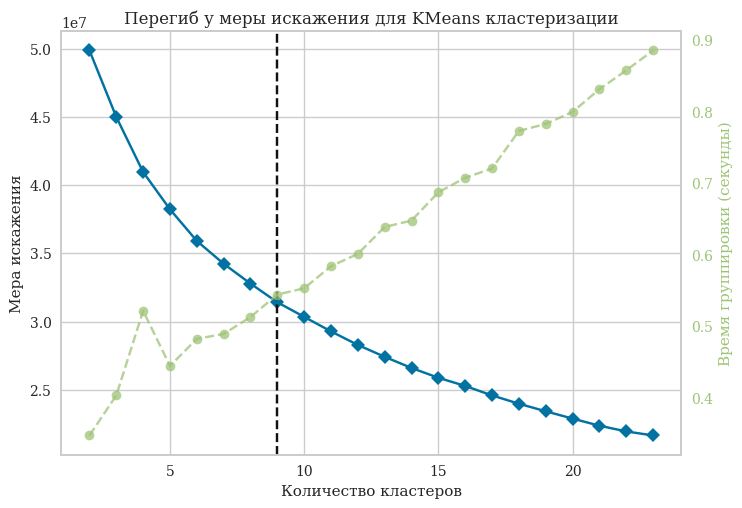

In [293]:
# Import ElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

swe_depth_c_n = (
    pd.DataFrame().from_dict({gauge_id: cell_dict["c_n"] for gauge_id, cell_dict in swe_depth.items()}).T
)
swe_depth_h_n = (
    pd.DataFrame().from_dict({gauge_id: cell_dict["h_n"] for gauge_id, cell_dict in swe_depth.items()}).T
)

raw_features = swe_depth_h_n.values

model = KMeans(random_state=42, init="k-means++", n_init=420)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 24), timings=True)
visualizer.fit(raw_features)  # Fit data to visualizer
visualizer.show();


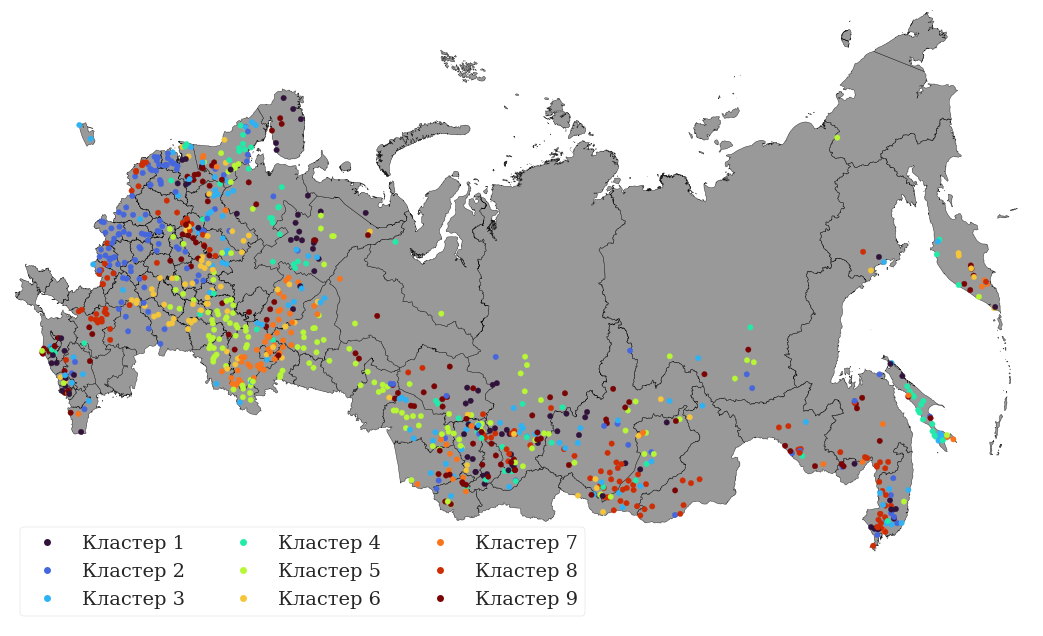

In [294]:
number_of_clusters = 9

cluster_alg = KMeans(n_clusters=number_of_clusters, random_state=42, init="k-means++", n_init=420)

yhat_AC = cluster_alg.fit_predict(raw_features)
swe_depth_c_n["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.NaN

gauges_file = gauges_file.combine_first(swe_depth_c_n).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    # list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
)


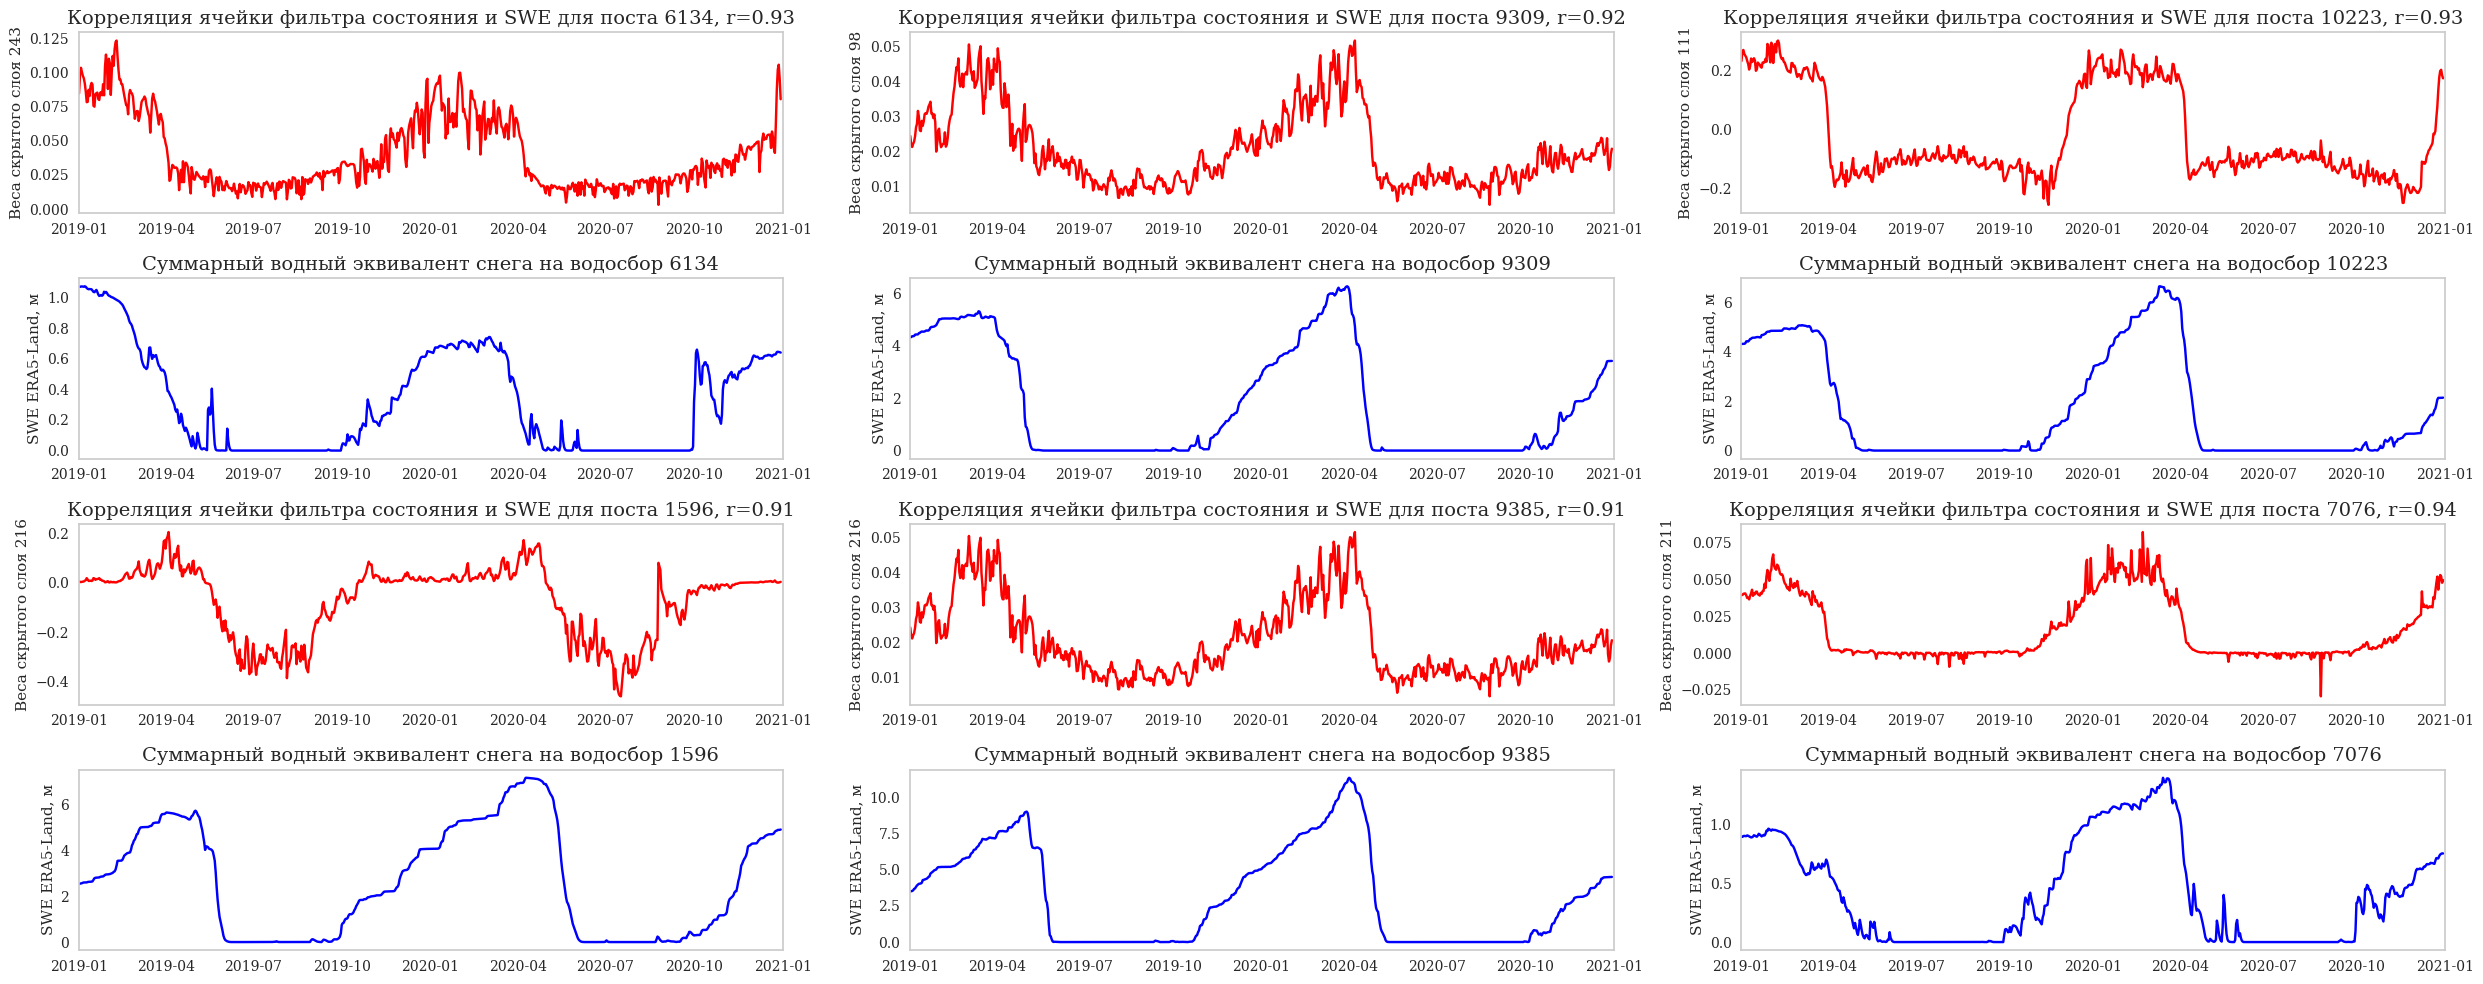

In [326]:
sample_swe = (
    swe_state.sort_values(by="r фильтр состояния", ascending=False)
    .head(420)
    .sample(n=6, random_state=42)
)


# Create a figure
fig = plt.figure(figsize=(25, 10))

# Define the GridSpec
gs = gridspec.GridSpec(4, 3)

# Add subplots
axs = [fig.add_subplot(gs[i, j]) for i in range(0, 4) for j in range(0, 3)]
cell_axs = [0, 1, 2, 6, 7, 8]
meteo_axs = [3, 4, 5, 9, 10, 11]

for gauge_id, cell_i, meteo_j in zip(sample_swe.index, cell_axs, meteo_axs):
    plot_cell = torch.cat([example_states["h_n"][:-1, -1, swe_depth[f"{gauge_id}"]["h_n"][0]]], dim=0)
    plot_cell = plot_cell.detach().numpy()

    meteo_array = (
        pd.read_csv(
            f"../geo_data/snow_and_subsurface/era5_land/snow_depth_water_equivalent/{gauge_id}.csv",
            index_col="date",
            parse_dates=["date"],
        )
        .loc[test_date_range.to_numpy()]
        .to_numpy()
        .ravel()
    ) / gauges_file.loc[gauge_id, "new_area"]

    ax_plot(
        gauge_id=f"{gauge_id}",
        cell_ax=axs[cell_i],
        cell_ax_title=f"Корреляция ячейки фильтра состояния и SWE для поста {gauge_id}, r={swe_state.loc[f'{gauge_id}', 'r фильтр состояния']:.2f}",
        cell_ax_ylabel=f"Веса скрытого слоя {swe_depth[gauge_id]['c_n'][0]}",
        meteo_ax=axs[meteo_j],
        meteo_ax_title=f"Суммарный водный эквивалент снега на водосбор {gauge_id}",
        meteo_ax_ylabel="SWE ERA5-Land, м",
        cell_data=plot_cell,
        meteo_data=meteo_array,
        data_range=test_date_range.to_numpy(),
    )

    plt.tight_layout()


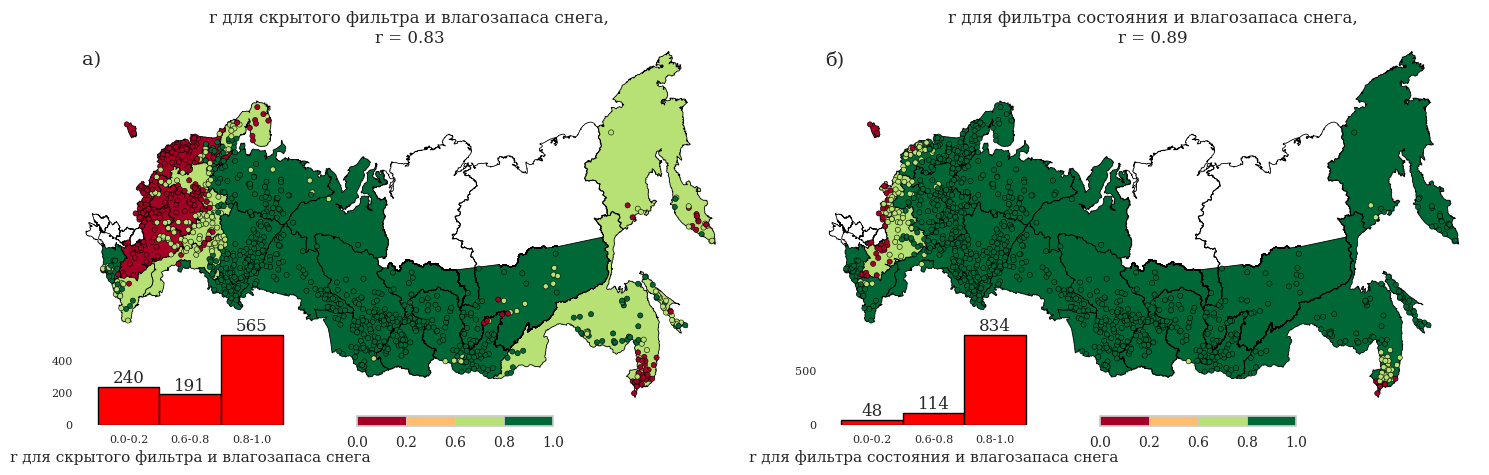

In [327]:
swe_h_n_r = swe_state["r скрытый фильтр"].median()
swe_c_n_r = swe_state["r фильтр состояния"].median()

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = swe_state.loc[[geom.intersects(gage_point) for gage_point in swe_state["geometry"]], :]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["r скрытый фильтр", "r фильтр состояния"]] = ugms_part[
        ["r скрытый фильтр", "r фильтр состояния"]
    ].median()

basin_districts.loc[[26, 27], ["r скрытый фильтр", "r фильтр состояния"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=swe_state,
    basemap_data=basemap_data,
    figsize=(15, 6),
    nrows=1,
    ncols=2,
    label_list=["а)", "б)"],
    list_of_limits=[0.0, 0.2, 0.6, 0.8, 1.0],
    columns_from_gdf=["r скрытый фильтр", "r фильтр состояния"],
    hist_name=[
        "r для скрытого фильтра и влагозапаса снега",
        "r для фильтра состояния и влагозапаса снега",
    ],
    with_histogram=True,
    title_text=[
        f"r для скрытого фильтра и влагозапаса снега,\nr = {swe_h_n_r:.2f}",
        f"r для фильтра состояния и влагозапаса снега,\nr = {swe_c_n_r:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


### Cell states vs Sub Surface Flow

In [328]:
subsurface_state = pd.DataFrame()
subsurface_depth = dict()

for gauge_id in tqdm(gauges_file.index):
    try:
        gauge_cor, gauge_state_cor = lstm_layer_correlation(
            state_dict=example_states,
            date_range=test_date_range.to_numpy(),
            meteo_array=pd.read_csv(
                f"../geo_data/snow_and_subsurface/era5_land/sub_surface_runoff/{gauge_id}.csv",
                index_col="date",
                parse_dates=["date"],
            )
            .loc[test_date_range]
            .to_numpy()
            .ravel(),
            correlation_threshold=0.6,
            data_name="Подземный сток",
        )
        subsurface_state.loc[gauge_id, "r скрытый фильтр"] = gauge_cor["h_n"]
        subsurface_state.loc[gauge_id, "r фильтр состояния"] = gauge_cor["c_n"]
        subsurface_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
        gauge_state_cor = {cell: [int(i[0]) for i in vals] for cell, vals in gauge_state_cor.items()}
        subsurface_depth[gauge_id] = gauge_state_cor
    except FileNotFoundError:
        subsurface_state.loc[gauge_id, "r скрытый фильтр"] = 0.01
        subsurface_state.loc[gauge_id, "r фильтр состояния"] = 0.01
        subsurface_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
    # subsurface_state.loc[gauge_id, "r "] = gauge_cor["h_n"]
subsurface_state = gpd.GeoDataFrame(subsurface_state, geometry="geometry", crs="epsg:4326")


  0%|          | 0/996 [00:00<?, ?it/s]

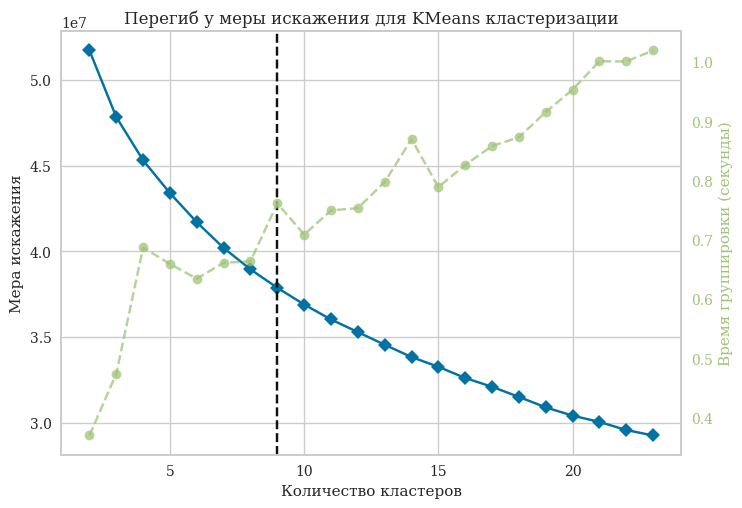

In [330]:
# Import ElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

subsurface_depth_c_n = (
    pd.DataFrame()
    .from_dict({gauge_id: cell_dict["c_n"] for gauge_id, cell_dict in subsurface_depth.items()})
    .T
)
subsurface_depth_h_n = (
    pd.DataFrame()
    .from_dict({gauge_id: cell_dict["h_n"] for gauge_id, cell_dict in subsurface_depth.items()})
    .T
)

raw_features = subsurface_depth_h_n.values

model = KMeans(random_state=42, init="k-means++", n_init=420)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 24), timings=True)
visualizer.fit(raw_features)  # Fit data to visualizer
visualizer.show();


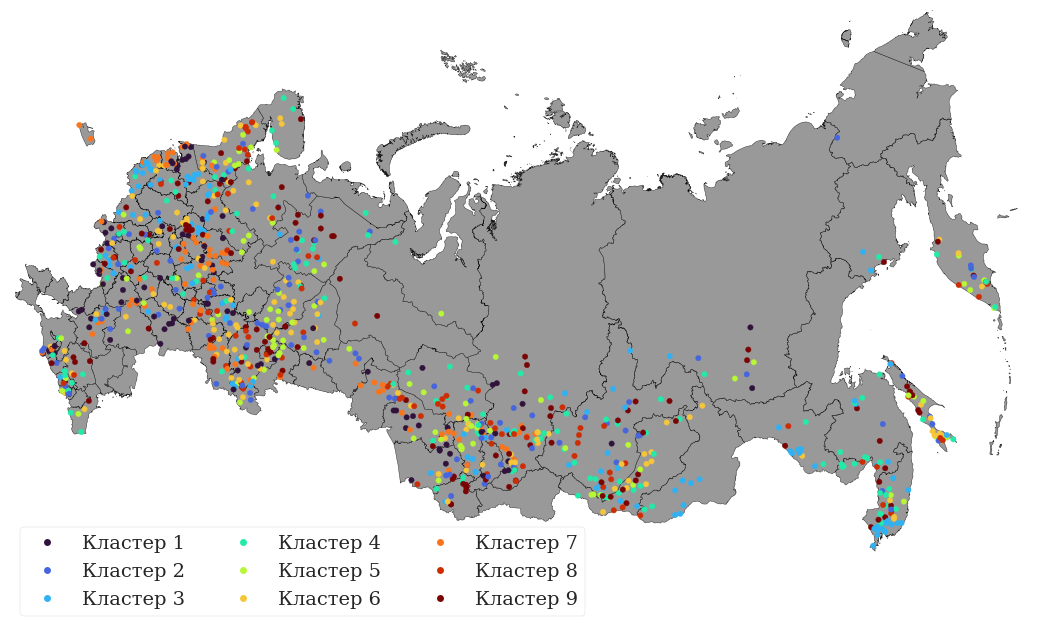

In [333]:
number_of_clusters = 9

cluster_alg = KMeans(n_clusters=number_of_clusters, random_state=42, init="k-means++", n_init=420)

yhat_AC = cluster_alg.fit_predict(raw_features)
subsurface_depth_h_n["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.NaN

gauges_file = gauges_file.combine_first(subsurface_depth_h_n).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    # list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
)


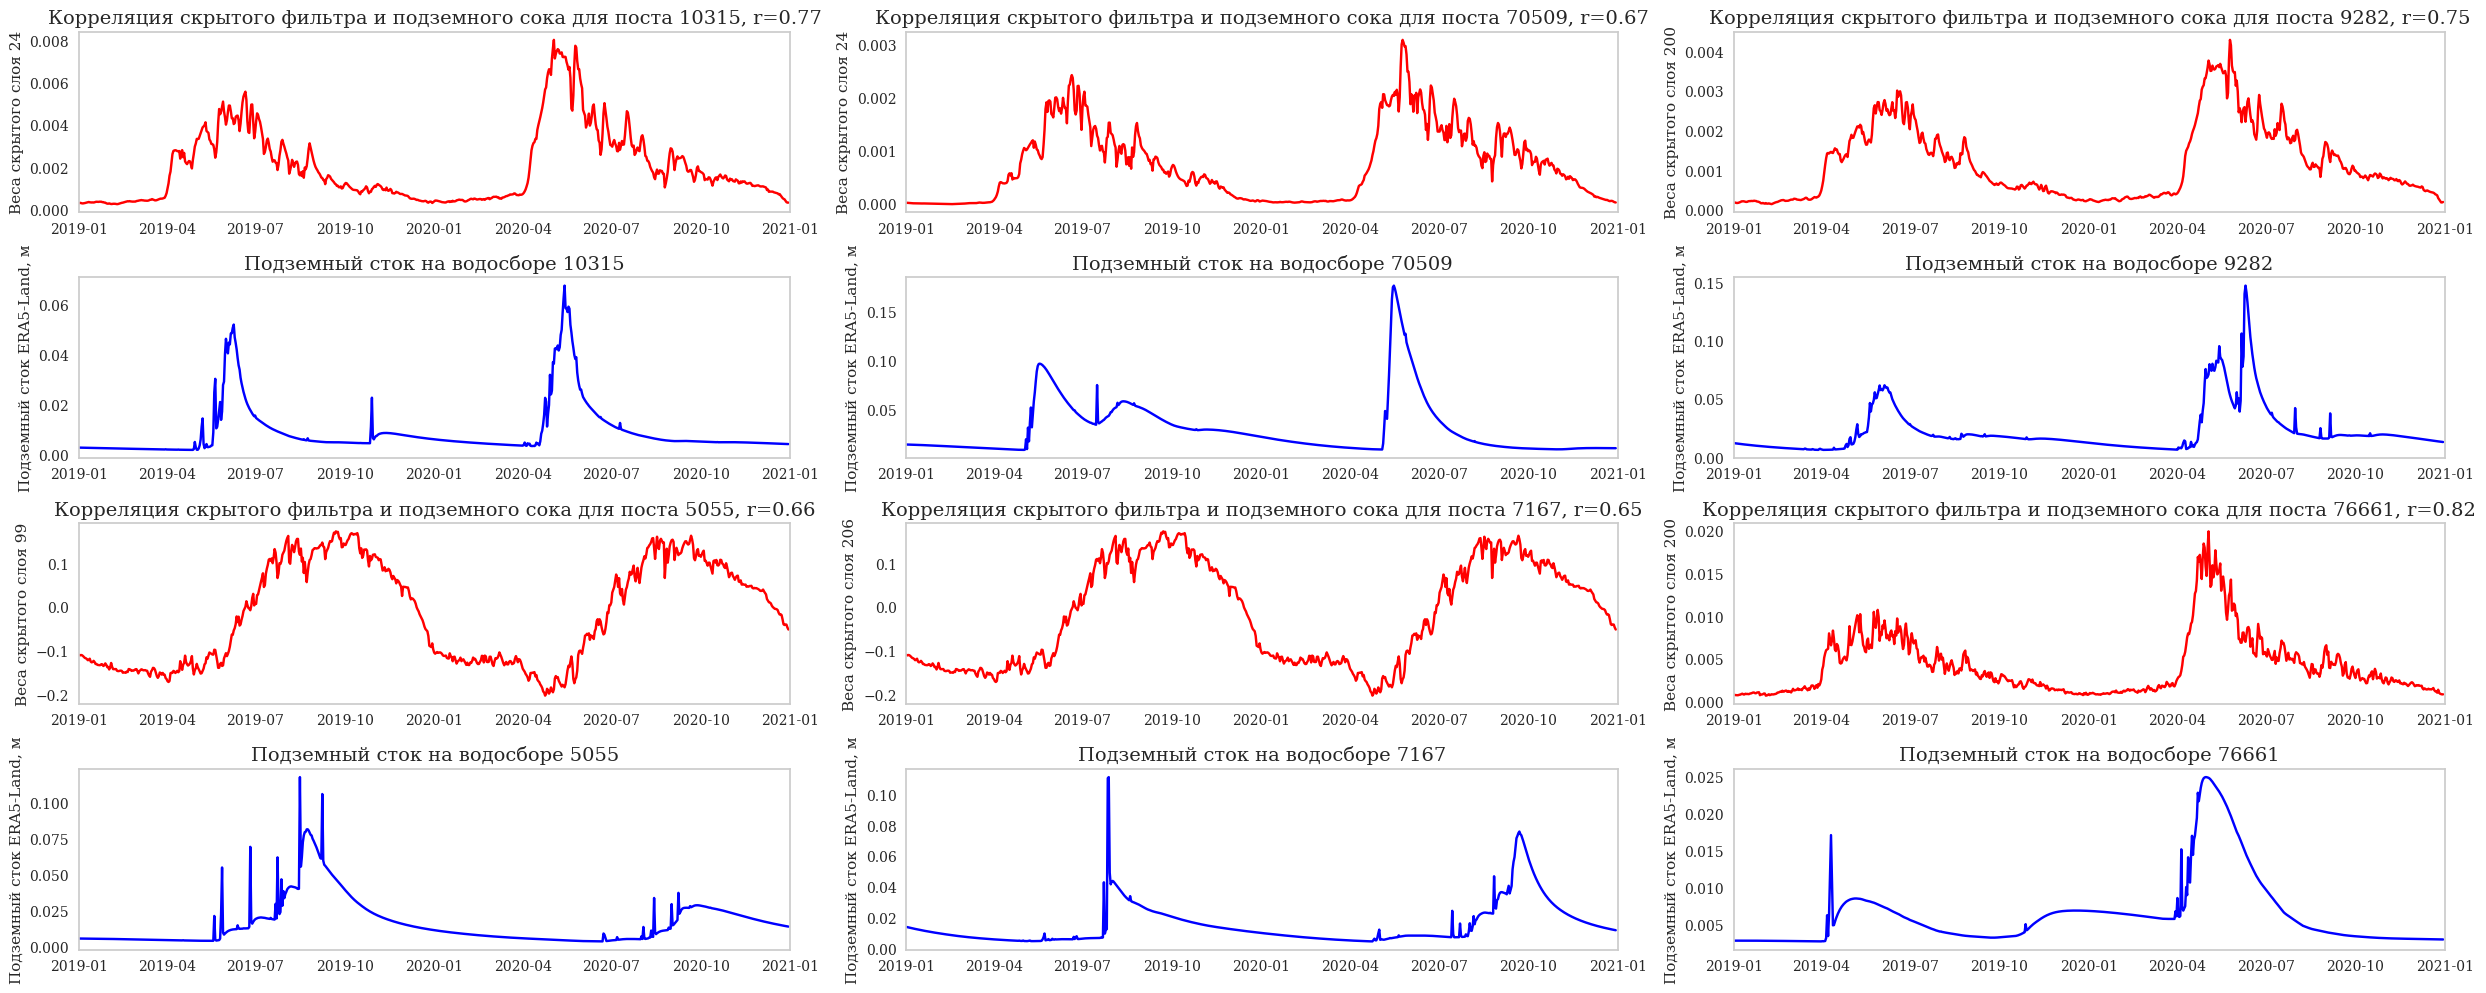

In [340]:
sample_subsurface = (
    subsurface_state.sort_values(by="r скрытый фильтр", ascending=False)
    .head(420)
    .sample(n=6, random_state=42)
)


# Create a figure
fig = plt.figure(figsize=(25, 10))

# Define the GridSpec
gs = gridspec.GridSpec(4, 3)

# Add subplots
axs = [fig.add_subplot(gs[i, j]) for i in range(0, 4) for j in range(0, 3)]
cell_axs = [0, 1, 2, 6, 7, 8]
meteo_axs = [3, 4, 5, 9, 10, 11]

for gauge_id, cell_i, meteo_j in zip(sample_subsurface.index, cell_axs, meteo_axs):
    plot_cell = torch.cat(
        [example_states["h_n"][:-1, -1, subsurface_depth[f"{gauge_id}"]["h_n"][0]]], dim=0
    )
    plot_cell = plot_cell.detach().numpy()

    meteo_array = (
        pd.read_csv(
            f"../geo_data/snow_and_subsurface/era5_land/sub_surface_runoff/{gauge_id}.csv",
            index_col="date",
            parse_dates=["date"],
        )
        .loc[test_date_range.to_numpy()]
        .to_numpy()
        .ravel()
    ) / gauges_file.loc[gauge_id, "new_area"]

    ax_plot(
        gauge_id=f"{gauge_id}",
        cell_ax=axs[cell_i],
        cell_ax_title=f"Корреляция скрытого фильтра и подземного сока для поста {gauge_id}, r={subsurface_state.loc[f'{gauge_id}', 'r скрытый фильтр']:.2f}",
        cell_ax_ylabel=f"Веса скрытого слоя {subsurface_depth[gauge_id]['c_n'][0]}",
        meteo_ax=axs[meteo_j],
        meteo_ax_title=f"Подземный сток на водосборе {gauge_id}",
        meteo_ax_ylabel="Подземный сток ERA5-Land, м",
        cell_data=plot_cell,
        meteo_data=meteo_array,
        data_range=test_date_range.to_numpy(),
    )

    plt.tight_layout()


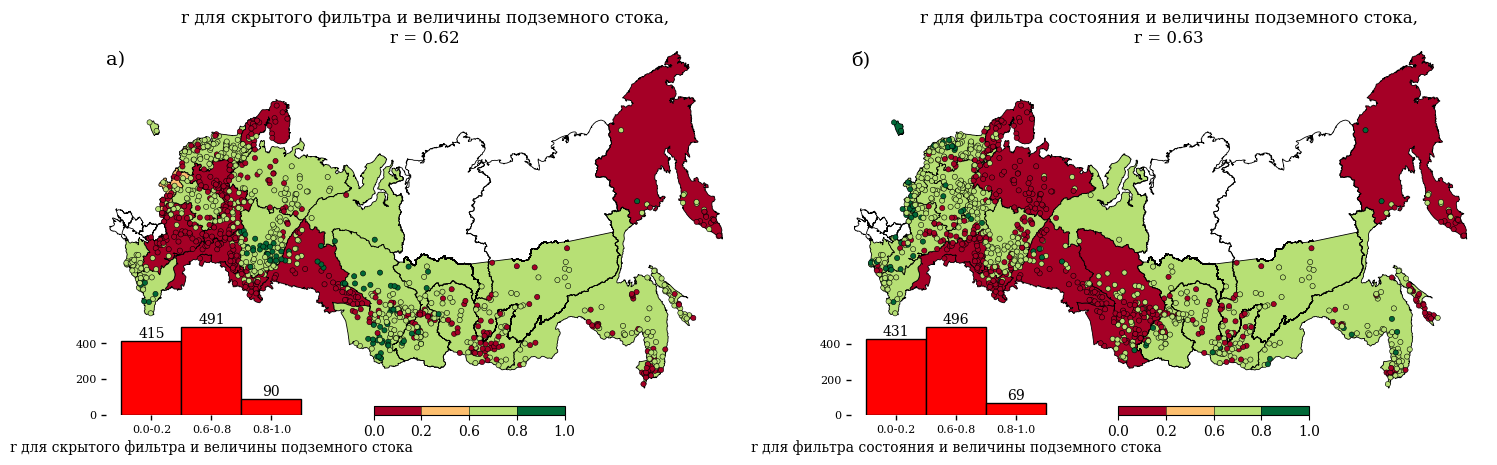

In [62]:
subsurface_h_n_r = subsurface_state["r скрытый фильтр"].median()
subsurface_c_n_r = subsurface_state["r фильтр состояния"].median()

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = subsurface_state.loc[
        [geom.intersects(gage_point) for gage_point in subsurface_state["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["r скрытый фильтр", "r фильтр состояния"]] = ugms_part[
        ["r скрытый фильтр", "r фильтр состояния"]
    ].median()

basin_districts.loc[[26, 27], ["r скрытый фильтр", "r фильтр состояния"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=subsurface_state,
    basemap_data=basemap_data,
    figsize=(15, 6),
    nrows=1,
    ncols=2,
    label_list=["а)", "б)"],
    list_of_limits=[0.0, 0.2, 0.6, 0.8, 1.0],
    columns_from_gdf=["r скрытый фильтр", "r фильтр состояния"],
    hist_name=[
        "r для скрытого фильтра и величины подземного стока",
        "r для фильтра состояния и величины подземного стока",
    ],
    with_histogram=True,
    title_text=[
        f"r для скрытого фильтра и величины подземного стока,\nr = {subsurface_h_n_r:.2f}",
        f"r для фильтра состояния и величины подземного стока,\nr = {subsurface_c_n_r:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


### Cell states vs Snow depth

In [341]:
snow_depth_state = pd.DataFrame()
snow_depth_depth = dict()

for gauge_id in tqdm(gauges_file.index):
    try:
        gauge_cor, gauge_state_cor = lstm_layer_correlation(
            state_dict=example_states,
            date_range=test_date_range.to_numpy(),
            meteo_array=pd.read_csv(
                f"../geo_data/snow_and_subsurface/era5_land/snow_depth/{gauge_id}.csv",
                index_col="date",
                parse_dates=["date"],
            )
            .loc[test_date_range]
            .to_numpy()
            .ravel(),
            correlation_threshold=0.6,
            data_name="Подземный сток",
        )
        snow_depth_state.loc[gauge_id, "r скрытый фильтр"] = gauge_cor["h_n"]
        snow_depth_state.loc[gauge_id, "r фильтр состояния"] = gauge_cor["c_n"]
        snow_depth_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
        gauge_state_cor = {cell: [int(i[0]) for i in vals] for cell, vals in gauge_state_cor.items()}
        snow_depth_depth[gauge_id] = gauge_state_cor
    except FileNotFoundError:
        snow_depth_state.loc[gauge_id, "r скрытый фильтр"] = 0.01
        snow_depth_state.loc[gauge_id, "r фильтр состояния"] = 0.01
        snow_depth_state.loc[gauge_id, "geometry"] = gauges_file.loc[gauge_id, "geometry"]
    # snow_depth_state.loc[gauge_id, "r "] = gauge_cor["h_n"]
snow_depth_state = gpd.GeoDataFrame(snow_depth_state, geometry="geometry", crs="epsg:4326")


  0%|          | 0/996 [00:00<?, ?it/s]

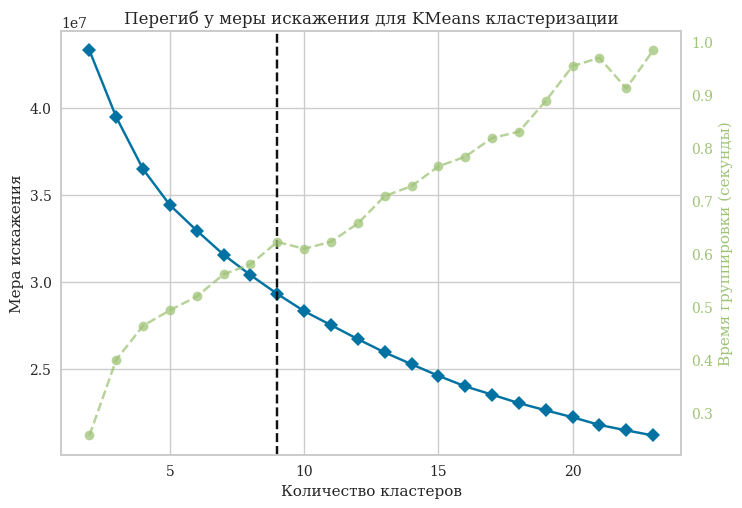

In [342]:
# Import ElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

snow_depth_depth_c_n = (
    pd.DataFrame()
    .from_dict({gauge_id: cell_dict["c_n"] for gauge_id, cell_dict in snow_depth_depth.items()})
    .T
)
snow_depth_depth_h_n = (
    pd.DataFrame()
    .from_dict({gauge_id: cell_dict["h_n"] for gauge_id, cell_dict in snow_depth_depth.items()})
    .T
)

raw_features = snow_depth_depth_c_n.values

model = KMeans(random_state=42, init="k-means++", n_init=420)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 24), timings=True)
visualizer.fit(raw_features)  # Fit data to visualizer
visualizer.show();


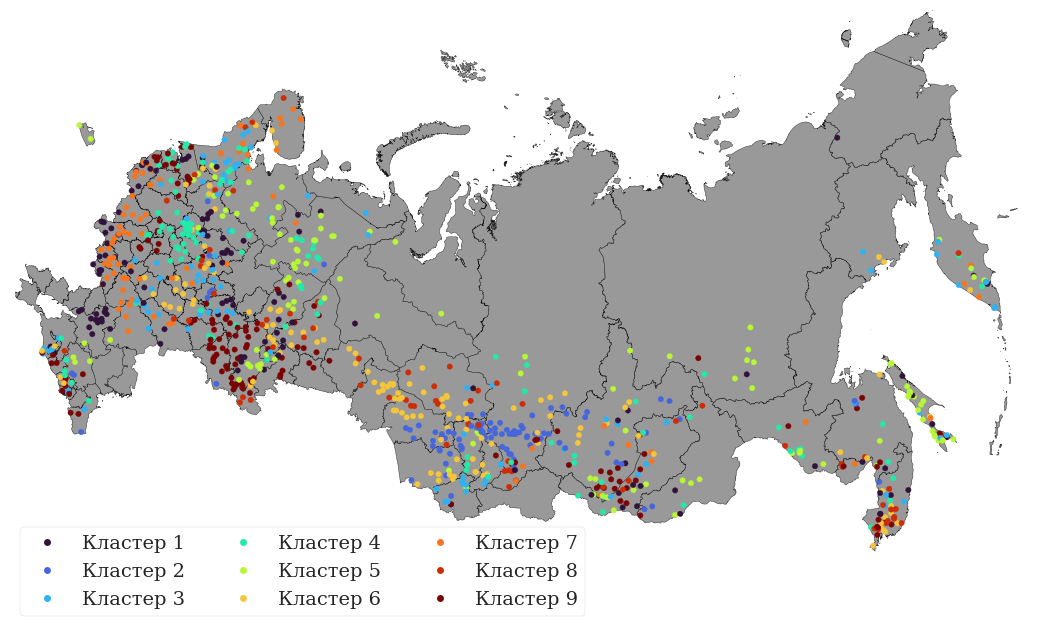

In [343]:
number_of_clusters = 9

cluster_alg = KMeans(n_clusters=number_of_clusters, random_state=42, init="k-means++", n_init=420)

yhat_AC = cluster_alg.fit_predict(raw_features)
subsurface_depth_h_n["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.NaN

gauges_file = gauges_file.combine_first(subsurface_depth_h_n).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    # list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
)


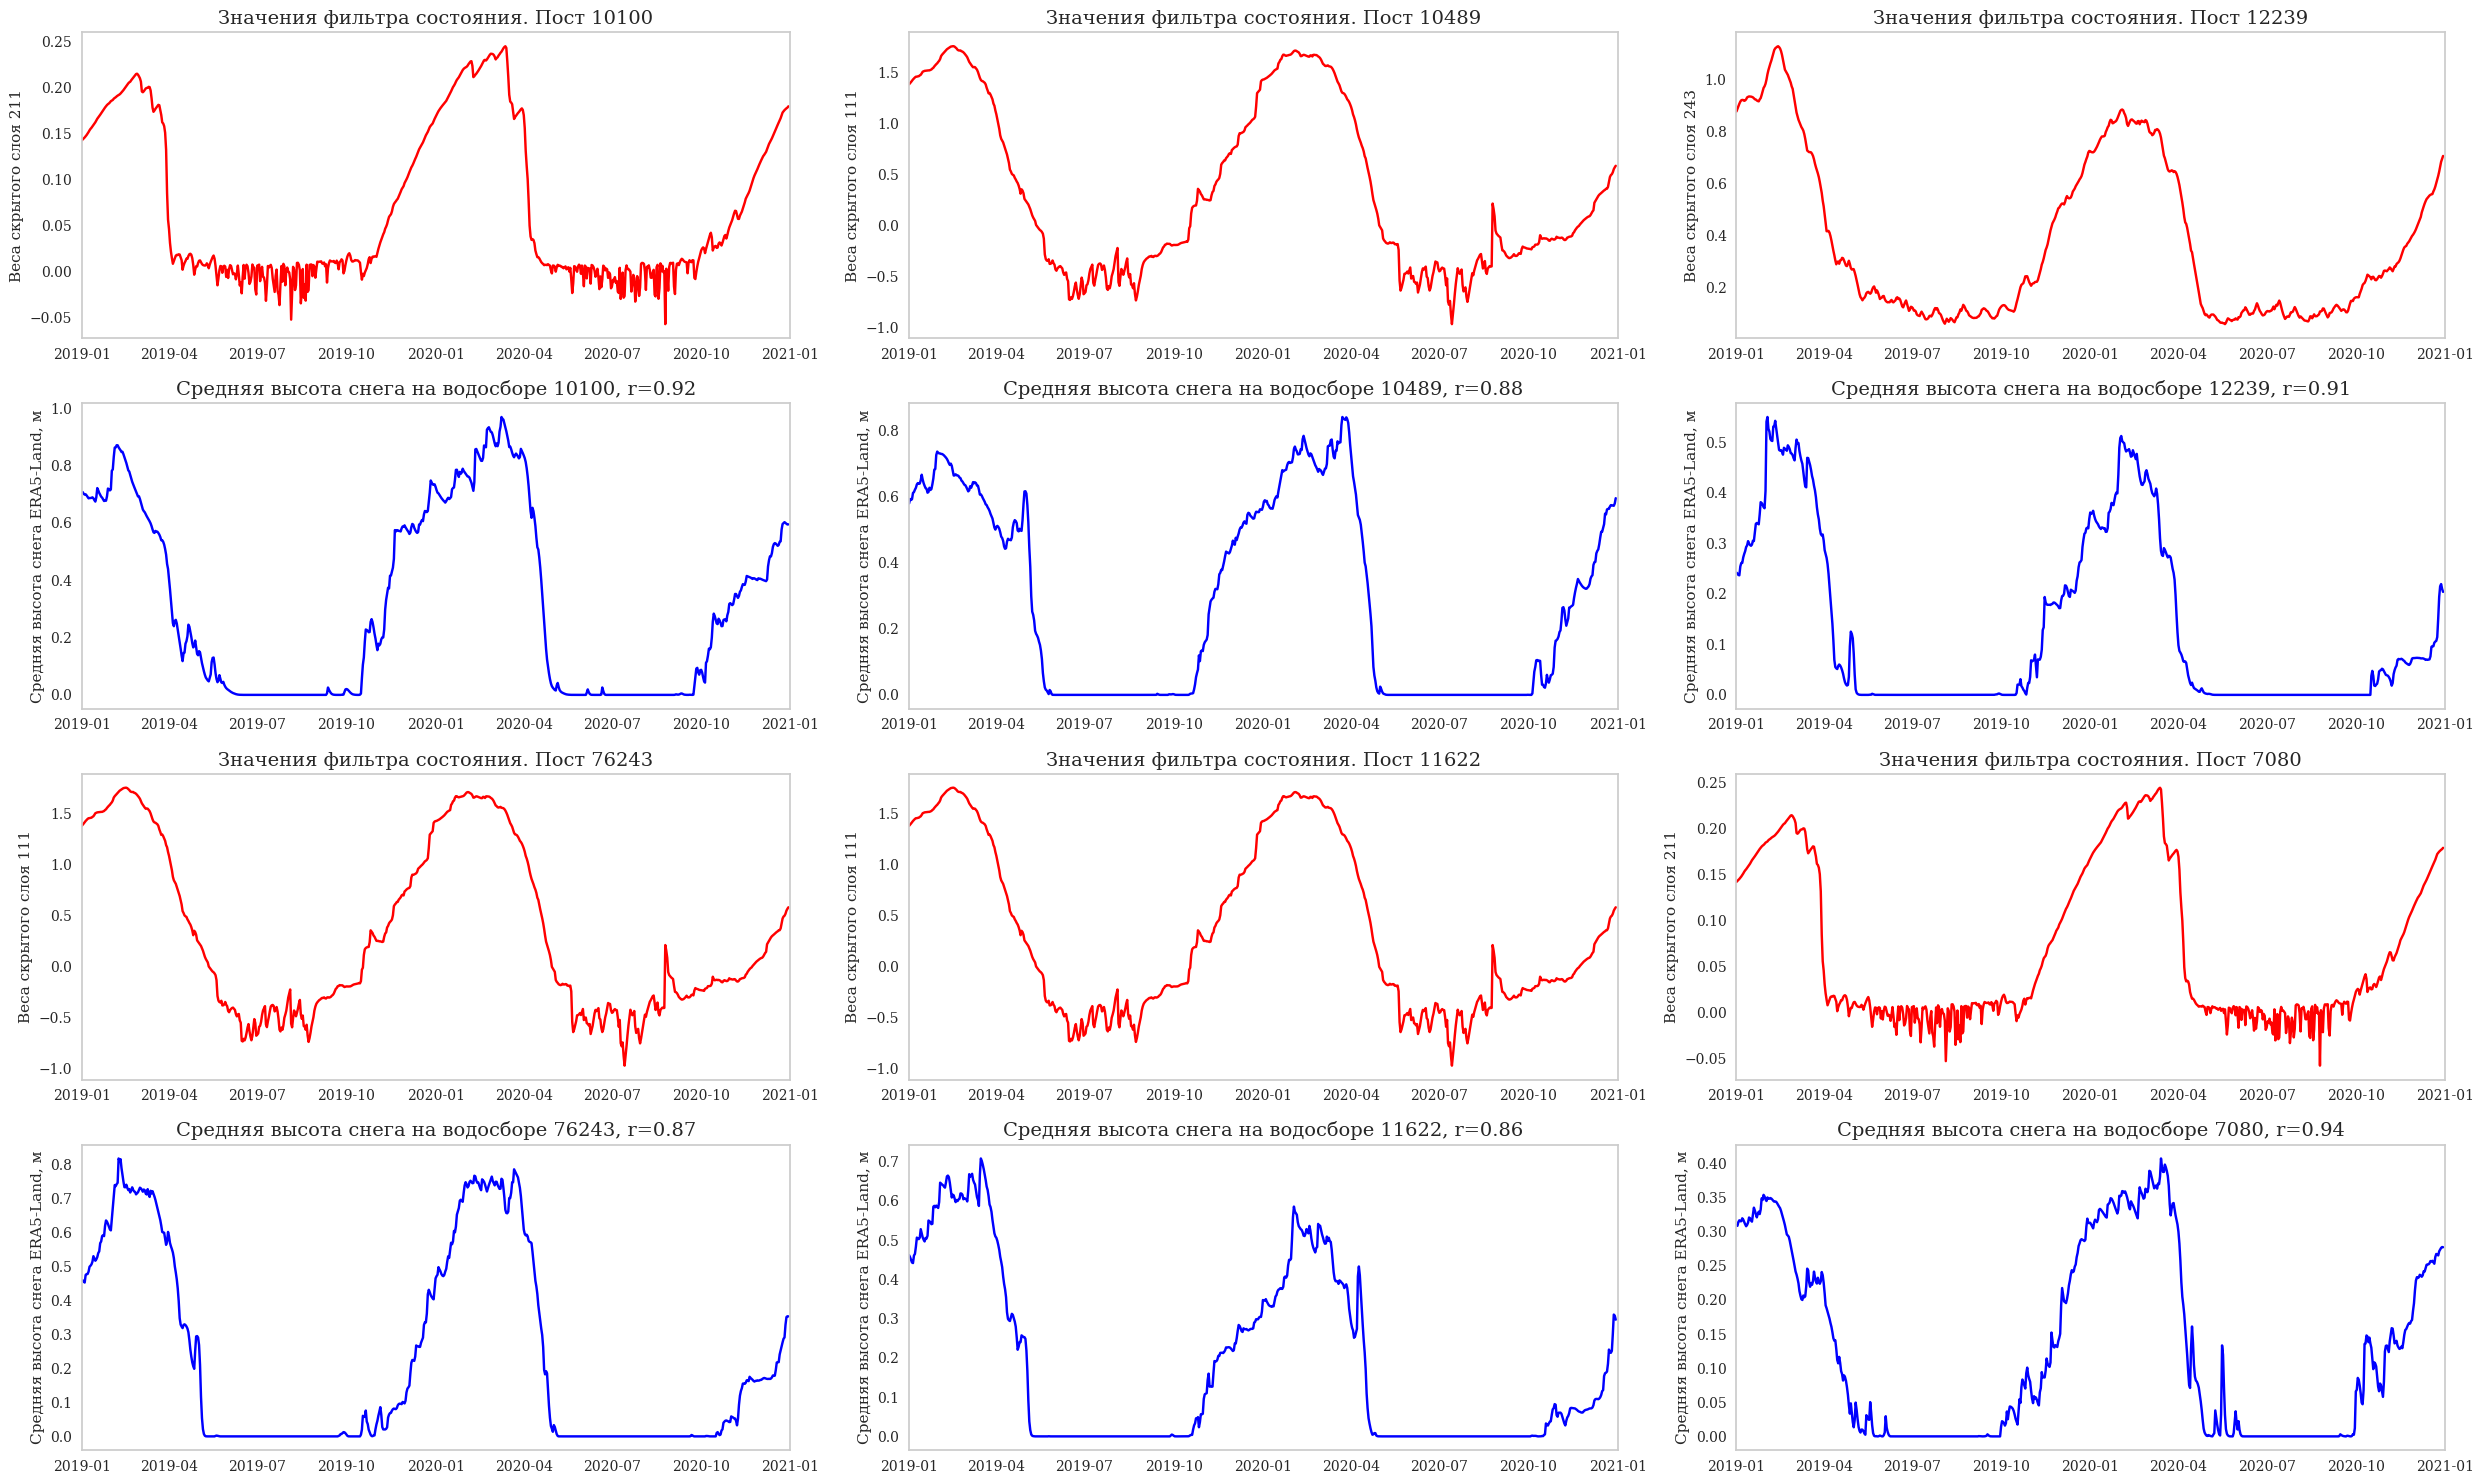

In [353]:
sample_snow_depth = (
    snow_depth_state.sort_values(by="r скрытый фильтр", ascending=False)
    .head(420)
    .sample(n=6, random_state=42)
)


# Create a figure
fig = plt.figure(figsize=(25, 15))

# Define the GridSpec
gs = gridspec.GridSpec(4, 3)

# Add subplots
axs = [fig.add_subplot(gs[i, j]) for i in range(0, 4) for j in range(0, 3)]
cell_axs = [0, 1, 2, 6, 7, 8]
meteo_axs = [3, 4, 5, 9, 10, 11]

for gauge_id, cell_i, meteo_j in zip(sample_snow_depth.index, cell_axs, meteo_axs):
    plot_cell = torch.cat(
        [example_states["c_n"][:-1, -1, snow_depth_depth[f"{gauge_id}"]["c_n"][0]]], dim=0
    )
    plot_cell = plot_cell.detach().numpy()

    meteo_array = (
        pd.read_csv(
            f"../geo_data/snow_and_subsurface/era5_land/snow_depth/{gauge_id}.csv",
            index_col="date",
            parse_dates=["date"],
        )
        .loc[test_date_range.to_numpy()]
        .to_numpy()
        .ravel()
    )

    ax_plot(
        gauge_id=f"{gauge_id}",
        cell_ax=axs[cell_i],
        cell_ax_title=f"Значения фильтра состояния. Пост {gauge_id}",
        cell_ax_ylabel=f"Веса скрытого слоя {snow_depth_depth[gauge_id]['c_n'][0]}",
        meteo_ax=axs[meteo_j],
        meteo_ax_title=f"Средняя высота снега на водосборе {gauge_id}, r={snow_depth_state.loc[f'{gauge_id}', 'r скрытый фильтр']:.2f}",
        meteo_ax_ylabel="Средняя высота снега ERA5-Land, м",
        cell_data=plot_cell,
        meteo_data=meteo_array,
        data_range=test_date_range.to_numpy(),
    )

    plt.tight_layout()


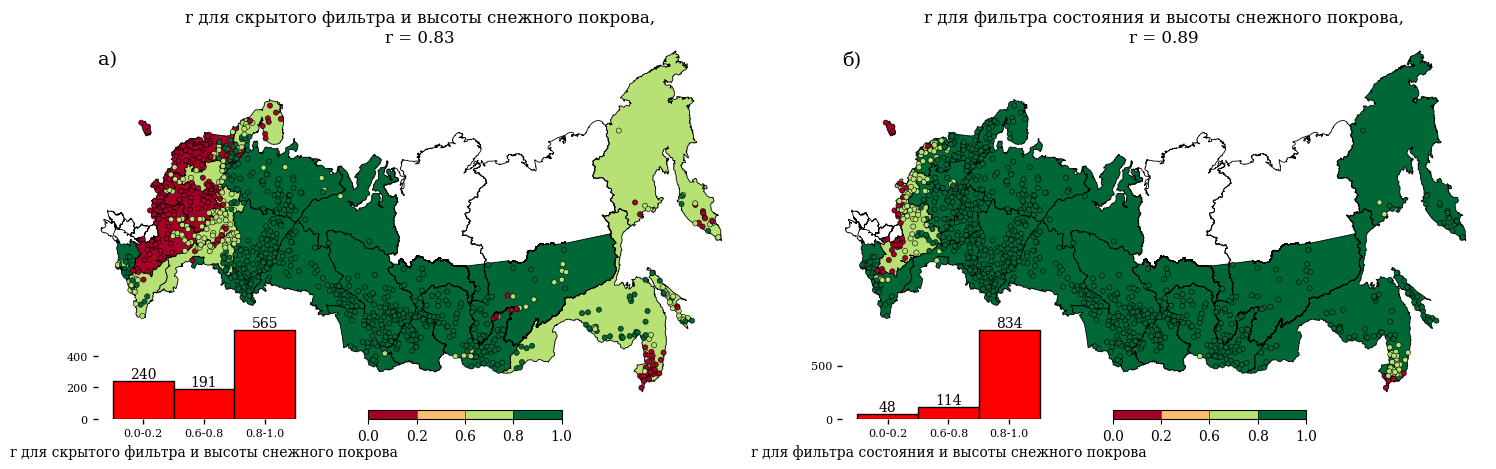

In [64]:
snow_depth_h_n_r = snow_depth_state["r скрытый фильтр"].median()
snow_depth_c_n_r = snow_depth_state["r фильтр состояния"].median()

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = snow_depth_state.loc[
        [geom.intersects(gage_point) for gage_point in snow_depth_state["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["r скрытый фильтр", "r фильтр состояния"]] = ugms_part[
        ["r скрытый фильтр", "r фильтр состояния"]
    ].median()

basin_districts.loc[[26, 27], ["r скрытый фильтр", "r фильтр состояния"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=snow_depth_state,
    basemap_data=basemap_data,
    figsize=(15, 6),
    nrows=1,
    ncols=2,
    label_list=["а)", "б)"],
    list_of_limits=[0.0, 0.2, 0.6, 0.8, 1.0],
    columns_from_gdf=["r скрытый фильтр", "r фильтр состояния"],
    hist_name=[
        "r для скрытого фильтра и высоты снежного покрова",
        "r для фильтра состояния и высоты снежного покрова",
    ],
    with_histogram=True,
    title_text=[
        f"r для скрытого фильтра и высоты снежного покрова,\nr = {snow_depth_h_n_r:.2f}",
        f"r для фильтра состояния и высоты снежного покрова,\nr = {snow_depth_c_n_r:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)
